In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
warmup_cutoff = 1000

pytorch = pd.read_csv('../results_ultimate_0/pytorch-yolo.csv')

tensorflow = pd.read_csv('../results_ultimate_0/tensorflow-yolo.csv')
tensorflow.elapsed_time /= 1e6

In [3]:
display(pytorch.head())
display(tensorflow.head())

,framework,model_name,phase,epoch,loss,performance,elapsed_time
0,PyTorch,YOLOv8m,latency,1,-1,1567.392334,37.240982
1,PyTorch,YOLOv8m,latency,2,-1,40.152000,37.298918
2,PyTorch,YOLOv8m,latency,3,-1,40.190079,37.259102
3,PyTorch,YOLOv8m,latency,4,-1,39.822655,37.244558
4,PyTorch,YOLOv8m,latency,5,-1,40.458687,37.228584


,framework,model_name,phase,epoch,loss,performance,elapsed_time
0,TensorFlow,YOLOv8m,latency,1,-1,-1,25643.713210
1,TensorFlow,YOLOv8m,latency,2,-1,-1,61.810275
2,TensorFlow,YOLOv8m,latency,3,-1,-1,59.338825
3,TensorFlow,YOLOv8m,latency,4,-1,-1,60.001043
4,TensorFlow,YOLOv8m,latency,5,-1,-1,60.165712


### Graph compilation for YOLOv8m in PyTorch's eager and compiled modes
`performance` - time measured by CUDA events (`model.predict()` in its entirety, with compilation etc) [ms]  
`elapsed_time` - time measured by ultralytics internal logger, just the inference [ms]  

In [4]:
graph_compilation = pytorch[pytorch.phase == "graph_compilation"]
graph_compilation = graph_compilation.drop(["model_name", "phase", "epoch", "loss", "elapsed_time"], axis=1)
graph_compilation = graph_compilation.groupby(["framework"])
mean = graph_compilation.mean()
std = graph_compilation.std()

print("Average time of compilation:")
display(mean)
print("Standard deviation:")
display(std)

Average time of compilation:


,performance
framework,
PyTorch,388.686741
PyTorch_compile,381.889463


Standard deviation:


,performance
framework,
PyTorch,77.730035
PyTorch_compile,72.976418


### Consistency comparison

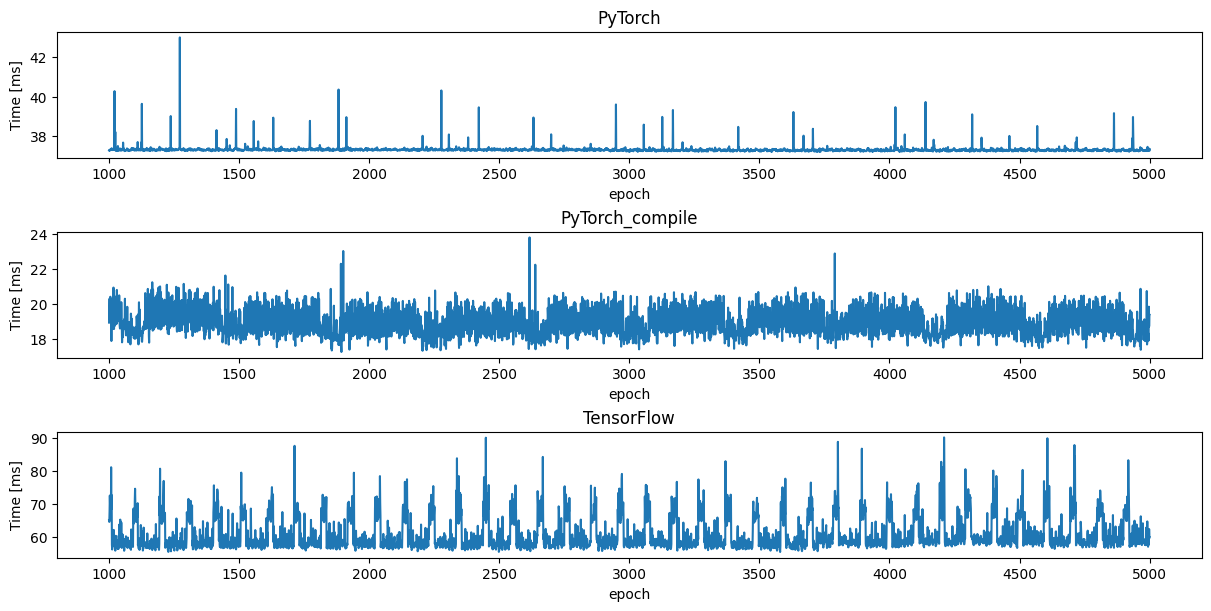

In [5]:
inference = pd.concat([pytorch, tensorflow])
inference = inference[(inference.phase == "latency") & (inference.epoch > warmup_cutoff)]

fig, axes = plt.subplots(3, 1, figsize=(12, 6), constrained_layout=True)

for framework, ax in zip(inference.framework.unique(), axes):
	data = inference[inference.framework == framework]
	sns.lineplot(x="epoch", y="elapsed_time", data=data, ax=ax)
	ax.set_title(framework)
	ax.set_ylabel("Time [ms]")

### Prediction times, inference on a single sample

In [6]:
inference = pd.concat([pytorch, tensorflow])
inference = inference[(inference.phase == "latency") & (inference.epoch > warmup_cutoff)]
inference = inference.drop(["model_name", "phase", "epoch", "loss", "performance"], axis=1)
inference = inference.groupby(["framework"])

mean = inference.mean().rename(columns={"elapsed_time": "t_mean"})
median = inference.median().rename(columns={"elapsed_time": "t_median"})
std = inference.std().rename(columns={"elapsed_time": "t_std"})
mind = inference.min().rename(columns={"elapsed_time": "t_min"})
maxd = inference.max().rename(columns={"elapsed_time": "t_max"})

infer_all_t = (
	pd.concat([mean, median, std, mind, maxd], axis="columns")
	.sort_values("t_mean")
	.rename(index={"PyTorch_compile": "torch.compile"})
	.reset_index()
)
infer_all_t

,framework,t_mean,t_median,t_std,t_min,t_max
0,torch.compile,18.948195,18.855572,0.753600,17.238140,23.822308
1,PyTorch,37.320938,37.299395,0.193989,37.199736,42.985678
2,TensorFlow,60.527215,58.400250,4.847135,55.355695,90.250798


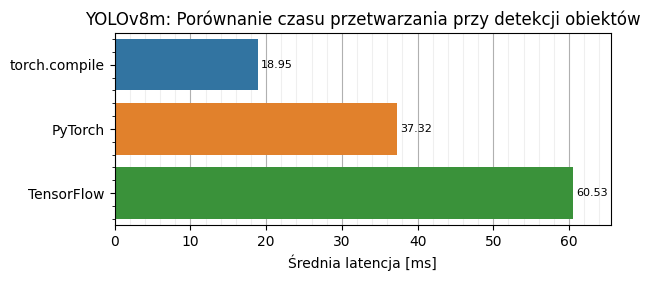

In [7]:
infer_all_t["hue"] = ["tc", "te", "tf"]

ax = sns.barplot(data=infer_all_t, y="framework", x="t_mean", zorder=2, orient="h", hue="hue")
ax.get_figure().set_size_inches(6.4, 2.5)
ax.set_ylabel("")
ax.set_xlabel("Średnia latencja [ms]")
ax.set_title("YOLOv8m: Porównanie czasu przetwarzania przy detekcji obiektów")
ax.get_legend().remove()

ax.grid(axis="x", which="major", zorder=1)
ax.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=False)
ax.grid(visible=True, axis="x", which="minor", alpha=0.2, zorder=1)

ax.set_xlim(right=65.5)

for container in ax.containers:
	ax.bar_label(container, fmt="{:.2f}", fontsize=8, padding=2)

ax.get_figure().savefig("../paper/plots/5.4-1.png", bbox_inches = "tight")